# Predicting the Past, United States Extension (Decay on) 

## Introduction
This is an add on of Predicting the Past, United States Extension where decay is now turned on. 
This add on includes comparisons between _CYCLUS_ output and CURIE data for the United States from 1968 to 2013 where decay is turned on for: 
 - Total spent fuel mass 
 - Mass of major isotopes in spent fuel 

The CURIE data is taken from UNF_ST&DARDS Unified Database and the Automatic Document Generator. 

The _CYCLUS_ data was generated by using published data of the commericial reactors that have operated in the United States. The _CYCLUS_ input file and simulation were generated in the original Predicting the Past, United States notebook. This notebook uses the SQL data file produced from the _CYCLUS_ simulation to do further analysis. 

Decay was turned on by adding 10 storage facilities to the input xml file that each take in consecutive ~ 5 years of spent fuel (with exception to 1st storage facility that takes ~ 10 years and 10th that takes everything after 2014) and outputs the spent fuel at year 2020. 

Most of the subsequent code is copied from united_states_extention.ipynb

** Import necessary libraries ** 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import csv
import collections
import dateutil.parser as date
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image, HTML, display
import seaborn as sns 

sys.path.append('../../../scripts/')
import analysis as an

** Run Cyclus simulation **

In [ ]:
!rm cyclus/united_states_decayon_underestm_33.sqlite
!cyclus -i ./cyclus/input/united_states_underestm_33.xml -o ./cyclus/united_states_decayon_underestm_33.sqlite --warn-limit 0

** Setting up to analyze sqlite file ** 

In [3]:
# Before this step, must download the output sqlite files from the fuel-cycles box. 
# fuel-cycle/cyclus_output/predicting_the_past_validation 
# and put into a directory named cyclus 

def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()


cursor_51 = get_cursor('cyclus/united_states_decayon_underestm.sqlite')
cursor_33 = get_cursor('cyclus/united_states_decayon_underestm_33.sqlite')

In [4]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep

** Get total spent fuel produced after cooling in spent fuel pool until 2020** 

In [ ]:
def total_spent_fuel_produced(cur): 
    """ Find timeseries of mass of spent fuel output by reactors 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    timeseries list of spent fuel output by reactors
    """
    coollist = ["cool_spent_uox1","cool_spent_uox2","cool_spent_uox3","cool_spent_uox4","cool_spent_uox5","cool_spent_uox6","cool_spent_uox7","cool_spent_uox8","cool_spent_uox9"]
    isotope_total_list = []
    
    init_yr, init_month, duration, timestep = get_timesteps(cursor)
    spent_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                             'INNER JOIN resources '
                             'ON transactions.resourceid = resources.resourceid '
                             'WHERE Commodity = "cool_spent_uox1" ' # must be changed to get each subsequent pool
                             'GROUP BY time ').fetchall()
    spent_fuel_list = an.get_timeseries(spent_fuel,duration,True)
    spent_fuel_total = np.sum(spent_fuel_list)
    return spent_fuel_total 

total_spentfuel = total_spent_fuel_produced(cursor_33)
total_spentfuel

In [ ]:
# underestm results (recorded from running above function for each pool)
total_spentfuel_1 = 1459.834024896255
total_spentfuel_2 = 6059.922964424133
total_spentfuel_3 = 7679.995986667509
total_spentfuel_4 = 10206.246547853802
total_spentfuel_5 = 7099.9127270253275
total_spentfuel_6 = 7499.889293245296
total_spentfuel_7 = 7199.918610978797
total_spentfuel_8 = 6899.824909870031
total_spentfuel_9 = 5999.907217196068

total_spentfuel_array = [total_spentfuel_1,total_spentfuel_2,total_spentfuel_3,total_spentfuel_4,total_spentfuel_5,total_spentfuel_6,total_spentfuel_7,total_spentfuel_8,total_spentfuel_9]
total_spentfuel_array_cum = np.cumsum(total_spentfuel_array)
print(total_spentfuel_array_cum)

** Get specific isotope composition from total spent fuel produced after cooling in spent fuel pool until 2020** 

In [5]:
def isotope_total_cum(cur,num):
    """ Find total isotopes present in spent fuel output by reactor for each cooling pool and sum cumulatively 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    num: nucid 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors added cumulatively for each cooling pool
    """    
    
    coollist = ["cool_spent_uox1","cool_spent_uox2","cool_spent_uox3","cool_spent_uox4","cool_spent_uox5","cool_spent_uox6","cool_spent_uox7","cool_spent_uox8","cool_spent_uox9"]
    isotope_total_list = []
    
    for x in range(0,9):
        cool_spent_uox = coollist[x]
    
        init_yr, init_month, duration, timestep = get_timesteps(cursor)
        isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                               'INNER JOIN resources '
                               'ON transactions.resourceid = resources.resourceid '
                               'LEFT OUTER JOIN compositions '
                               'ON resources.qualid = compositions.qualid '
                               'WHERE Commodity =:cool_spent_uox AND nucid =:num ' # must specify isotope and pool
                               ' GROUP BY time ',{"cool_spent_uox": cool_spent_uox, "num":num}).fetchall()
        isotope_list = an.get_timeseries(isotopes,duration,True)
        isotope_total = np.sum(isotope_list)
        isotope_total_list.append(isotope_total)
    
    isotope_total_cum = np.cumsum(isotope_total_list)
    
    return isotope_total_cum

In [6]:
# Pu-239 
Pu239_51 = isotope_total_cum(cursor_51,942390000)
Pu239_33 = isotope_total_cum(cursor_33,942390000)

array([  7.61217795,  38.94796372,  79.00545542, 131.97899198,
       168.48560668, 206.18886033, 243.76233317, 279.77448846,
       310.37906024])

In [8]:
# Pu-240
Pu240_51 = isotope_total_cum(cursor_51,942400000)
Pu240_33 = isotope_total_cum(cursor_33,942400000)

In [17]:
# Cs-137
Cs137_51= isotope_total_cum(cursor_51,551370000)
Cs137_33= isotope_total_cum(cursor_33,551370000)

In [18]:
# Sr-90
Sr90_51= isotope_total_cum(cursor_51,380900000)
Sr90_33= isotope_total_cum(cursor_33,380900000)

In [ ]:
# Am-241
Am241_51= isotope_total_cum(cursor_51,952410000)
Am241_33= isotope_total_cum(cursor_33,952410000)

In [ ]:
# U-238
U238_51= isotope_total_cum(cursor_51,922380000)
U238_33= isotope_total_cum(cursor_33,922380000)

## CURIE Data Analysis 

In [9]:
names = ['assembly_id','reactor_id', 'reactor_type', 'initial_uranium_kg','initial_enrichment','discharge_burnup','discharge_date','discharge_time','total_assembly_decay_heat_kw','name','evaluation_date','total_mass_g','total_radioactivity_curies']
df = pd.read_csv('SNF_nuclide_2020_07_01.dat',
                  sep='\s+',
                  index_col=False, 
                  names = names)

In [10]:
date_isotope_mass = df[['discharge_date','name','total_mass_g']]
date_mass = df[['discharge_date','total_mass_g']]

In [11]:
spent_fuel_mass = date_mass.groupby('discharge_date').sum()
spent_fuel_mass_cum = spent_fuel_mass.cumsum()
spent_fuel_mass_cum['total_mass_g'] = spent_fuel_mass_cum['total_mass_g'].apply(lambda x: x*0.000001)
spent_fuel_mass_cum = spent_fuel_mass_cum.rename(columns = {'total_mass_g':'total_mass_MTHM_CURIE'})
spent_fuel_mass_cum.index.names = ['discharge_date']

In [12]:
CURIE_isotope = date_isotope_mass.pivot_table(index='discharge_date',columns='name',aggfunc=sum)
CURIE_isotope_cum_all = CURIE_isotope.cumsum()

** CURIE and CYCLUS data on same plot for total spent fuel mass** 

In [ ]:
index = spent_fuel_mass_cum.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2014-01-01']
data = spent_fuel_mass_cum.values
data2 = total_spentfuel_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/cumulative_mass_spent_fuel_decayon.png', dpi=300)

** CURIE and CYCLUS data on same plot for total spent fuel mass for specific isotopes** 

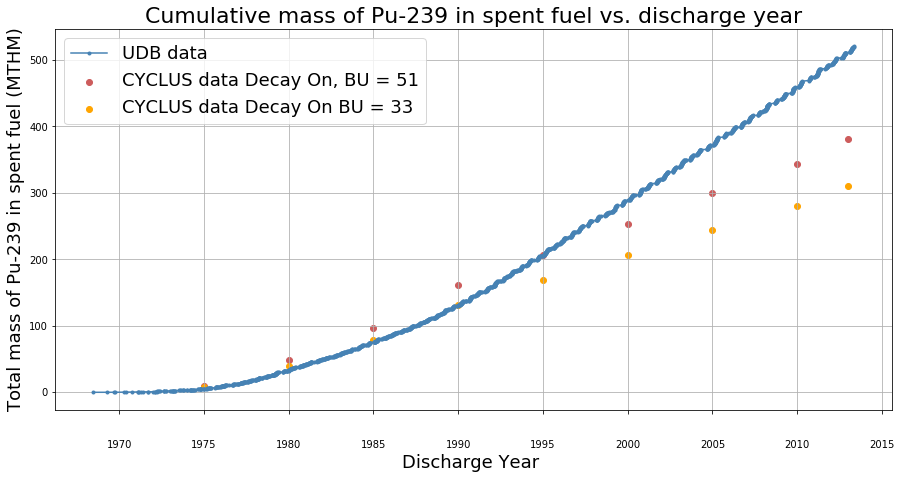

In [29]:
# Pu 239 
CURIE_isotope_single_pu239 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'pu-239')] # isotope name 
CURIE_isotope_single_pu239 = CURIE_isotope_single_pu239.to_frame()
CURIE_isotope_single_pu239 = CURIE_isotope_single_pu239.multiply(0.000001)
index = CURIE_isotope_single_pu239.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_pu239.columns.values)
data = CURIE_isotope_single_pu239.values
data2 = underestm_Pu239_array_cum
data3 = Pu239
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On, BU = 51', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On BU = 33', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Pu-239 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Pu-239 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Pu-239_cumulative_mass_spent_fuel_decayon.png', dpi=300)

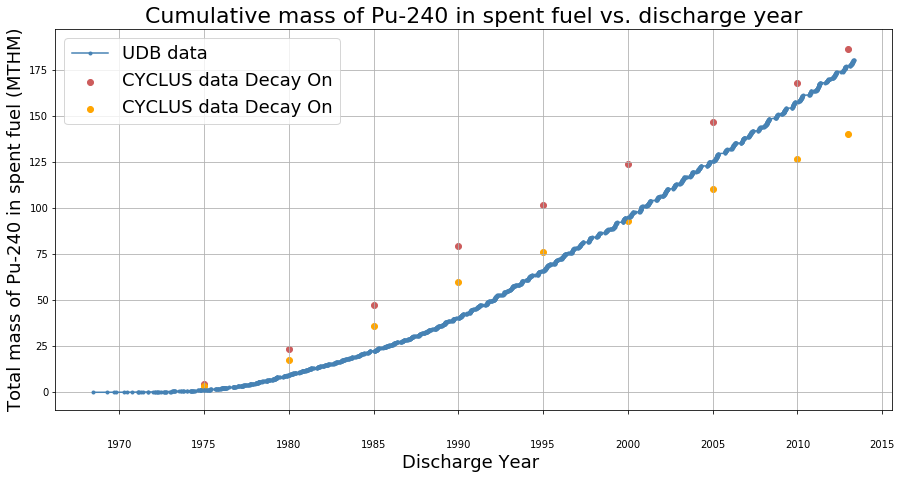

In [25]:
# Pu 240
CURIE_isotope_single_pu240 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'pu-240')] # isotope name 
CURIE_isotope_single_pu240 = CURIE_isotope_single_pu240.to_frame()
CURIE_isotope_single_pu240 = CURIE_isotope_single_pu240.multiply(0.000001)
index = CURIE_isotope_single_pu240.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_pu240.columns.values)
data = CURIE_isotope_single_pu240.values
data2 = underestm_Pu240_array_cum
data3 = Pu240_33
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Pu-240 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Pu-240 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Pu-240_cumulative_mass_spent_fuel_decayon.png', dpi=300)

In [ ]:
# U 238
CURIE_isotope_single_u238 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'u-238')] # isotope name 
CURIE_isotope_single_u238 = CURIE_isotope_single_u238.to_frame()
CURIE_isotope_single_u238 = CURIE_isotope_single_u238.multiply(0.000001)
index = CURIE_isotope_single_u238.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_u238.columns.values)
data = CURIE_isotope_single_u238.values
data2 = underestm_U238_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of U-238 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of U-238 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/U-238_cumulative_mass_spent_fuel_decayon.png', dpi=300)

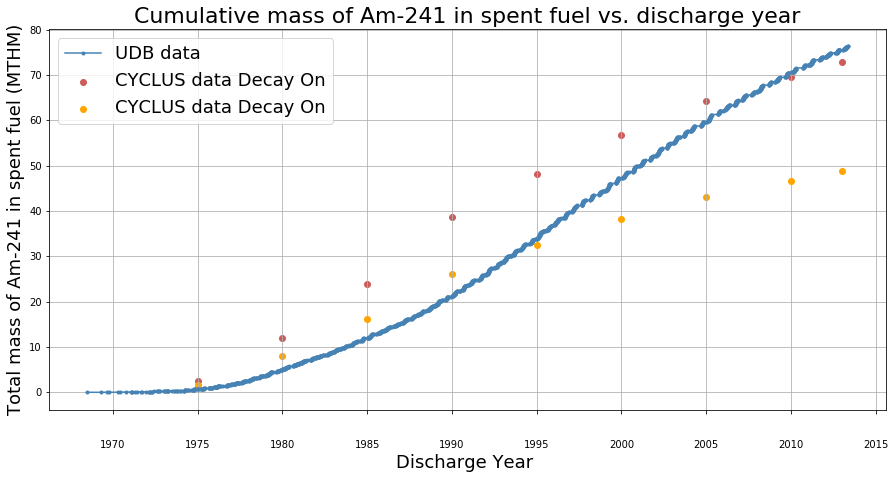

In [26]:
# Am-241
CURIE_isotope_single_am241 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'am-241')] # isotope name 
CURIE_isotope_single_am241 = CURIE_isotope_single_am241.to_frame()
CURIE_isotope_single_am241 = CURIE_isotope_single_am241.multiply(0.000001)
index = CURIE_isotope_single_am241.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_am241.columns.values)
data = CURIE_isotope_single_am241.values
data2 = underestm_Am241_array_cum
data3 = underestm33_Am241_array_cum
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)
col_no = -1

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Am-241 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Am-241 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Am-241_cumulative_mass_spent_fuel_decayon.png', dpi=300)

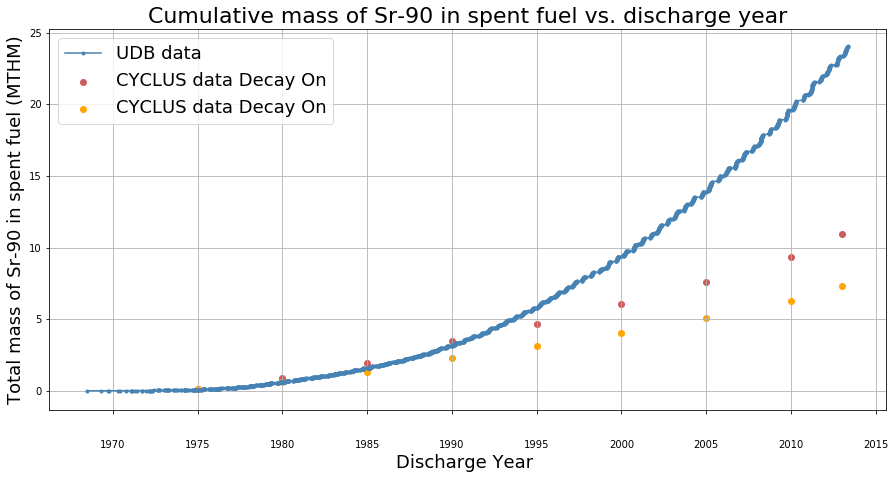

In [27]:
# Sr-90
CURIE_isotope_single_sr90 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'sr-90')] # isotope name 
CURIE_isotope_single_sr90 = CURIE_isotope_single_sr90.to_frame()
CURIE_isotope_single_sr90 = CURIE_isotope_single_sr90.multiply(0.000001)
index = CURIE_isotope_single_sr90.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_sr90.columns.values)
data = CURIE_isotope_single_sr90.values
data2 = underestm_Sr90_array_cum
data3 = Sr90_33
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Sr-90 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Sr-90 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Sr-90_cumulative_mass_spent_fuel_decayon.png', dpi=300)

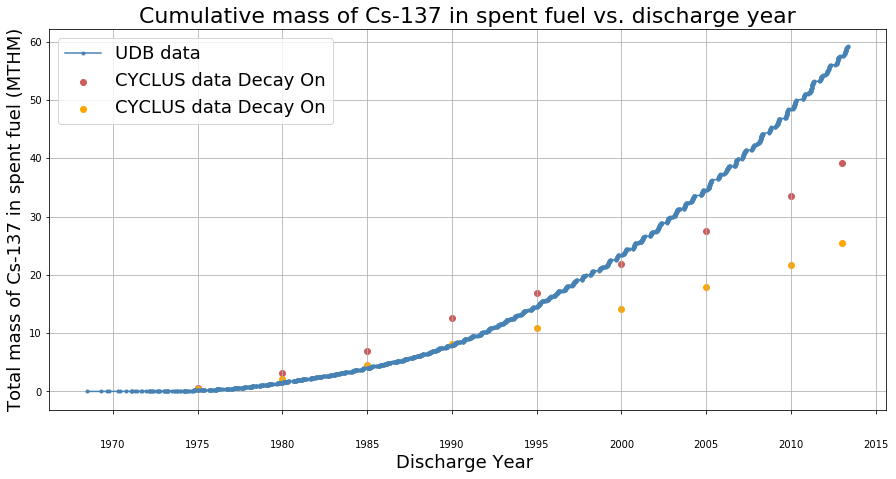

In [28]:
# Cs-137
CURIE_isotope_single_cs137 = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'cs-137')] # isotope name 
CURIE_isotope_single_cs137 = CURIE_isotope_single_cs137.to_frame()
CURIE_isotope_single_cs137 = CURIE_isotope_single_cs137.multiply(0.000001)
index = CURIE_isotope_single_cs137.index.values
index2 = ['1975-01-01','1980-01-01','1985-01-01','1990-01-01','1995-01-01','2000-01-01','2005-01-01','2010-01-01','2013-01-01']
column = list(CURIE_isotope_single_cs137.columns.values)
data = CURIE_isotope_single_cs137.values
data2 = underestm_Cs137_array_cum
data3 = Cs137_33
dts = pd.to_datetime(index)
dts2 = pd.to_datetime(index2)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(dts, data,color = 'steelblue', label='UDB data', marker = ".")
ax.scatter(dts2, data2, color = 'indianred', label='CYCLUS data Decay On', marker = "o")
ax.scatter(dts2, data3, color = 'orange', label='CYCLUS data Decay On', marker = "o")
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n%Y'))
ax.set_xlabel('Discharge Year ', fontsize=18)
ax.set_ylabel('Total mass of Cs-137 in spent fuel (MTHM)', fontsize=18)
ax.set_title('Cumulative mass of Cs-137 in spent fuel vs. discharge year', fontsize=22)
plt.savefig('figures/Cs-137_cumulative_mass_spent_fuel_decayon.png', dpi=300)